![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+-+Municipal+Securities.ipynb)

# Document Q&A: Municipal Securities

**What?**

Ask questions of a municipal security document.

**Sources:**

The pdf for [New York State Housing Finance Agency](https://emma.msrb.org/P11635483-P11259775-P11685317.pdf) - 200 pages.

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.preview.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**Prerequisites**

This notebook uses Vertex AI and Document AI services for processing data while also using Google Cloud Storage And Google BigQuery for data storage and retrieval.  If you are running this notebook from Colab or another environment where your user id is authenticated then your account will need roles/permissions that allow working with these services.  If you are running this from a Vertex AI Workbench Notebook instance then it is running as a service account which will need the roles/permission that allow working with these services. 

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20-%20Municipal%20Securities.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [13]:
REGION = 'us-central1'
EXPERIMENT = 'municipal-security'
SERIES = 'applied-genai'

# save results in: GCS, BQ, ALL
SAVE_IN = 'GCS'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source document (PDF): can be http or gs://
#source_document = 'https://emma.msrb.org/P11635483-P11259775-P11685317.pdf'
source_document = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/P11635483-P11259775-P11685317.pdf'

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "How will bond proceeds be used?"

Packages

In [14]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

Clients

In [15]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [5]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [6]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.044936999678611755,
 0.012650316581130028,
 0.01574002020061016,
 0.05652769282460213,
 0.012828737497329712]

Test test generation (llm) model:

In [7]:
textgen_model.predict(question)

Baseball is a bat-and-ball game played between two teams of nine players on a field in the shape of a diamond. The game is played with a hard, round ball and a bat. The object of the game is for a team to score more runs than the opposing team.

A run is scored when a player advances around all four bases in the correct order. The bases are located at first, second, third, and home plate. A player can advance to the next base by hitting the ball and running to the next base before the ball is thrown to the fielder covering that base.

The game is

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [8]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Document

Get the source PDF from GCS or a URL and store as a list of pages: `pdfs`.

Get Location of File

In [9]:
if source_document.startswith('http'):
    document_location = 'URL'
    print('Use requests to get online document')
elif source_document.startswith('gs'):
    document_location = 'GCS'
    print('Use GCS to get document in GCS')
else:
    document_location = 'UNKNOWN'
    print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document


Copy the PDF to memory:

In [10]:
if document_location == 'URL':
    response = requests.get(source_document).content
elif document_location == 'GCS':
    blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
    response = blob.download_as_bytes()

In [11]:
type(response)

bytes

Split the PDF into a document per page:

In [12]:
pdf = PyPDF2.PdfReader(io.BytesIO(response))

In [13]:
len(pdf.pages)

192

In [14]:
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [15]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents')

True

In [16]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    

elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)    
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents'):
    print('Copying previous run from BigQuery')
    
    # load results: the raw data from docai parsing
    results = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_results` ORDER BY metadata.vme_id').to_dataframe().to_dict('records')
    
    # load documents: the perpared results from the docai parsing results
    documents = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_documents` ORDER BY metadata.vme_id').to_dataframe().to_dict('records')
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as base64 encoded bytes in BQ and retrieved in that format
                result['pages'][0]['image']['content']
            )
        )
        page_images.append(document_image) 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

Copying previous run from GCS


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [17]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [18]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [19]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
    results = [None] * len(pdfs)
    start = time.time()
    with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
        futures = [
            executor.submit(
                docai_runner,
                p, start,
                documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
            ) for p, pdf in enumerate(pdfs)
        ]
        for future in concurrent.futures.as_completed(futures):
          #result = futures[future]
          results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

Using Prior Results


In [20]:
len(pdfs), len(results)

(192, 192)

In [21]:
if PRIOR_PARSE:
  print('Using Prior Documents Preparation')
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):
    
    # add order to results:
    results[r]['metadata'] = dict(vme_id = str(r))
    
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  vme_id = str(len(documents)),
                  filename = source_document.split('/')[-1],
                  source_document = source_document
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      # only use paragraph that are not within table boundaries
      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    vme_id = str(len(documents)),
                    filename = source_document.split('/')[-1],
                    source_document = source_document
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

Using Prior Documents Preparation


1431

In [22]:
print(documents[300]['page_content'])

(H) One base, if a ball, pitched to the batter, or thrown by the
pitcher from his position on the pitcher's plate to a base
to catch a runner, goes into a stand or a bench, or over or
through a field fence or backstop. The ball is dead;
3


In [23]:
print(documents[300]['metadata'])

{'page': 43, 'paragraph': 6, 'vme_id': '300', 'filename': 'wqn5ah4c3qtivwx3jatm.pdf', 'source_document': 'https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf'}


---
## Get Embeddings


In [24]:
rate_limit_minute = 150

In [25]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

Embeddings created on previous run.


## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [26]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(1431, 768)

In [27]:
type(results) == list

True

In [28]:
if type(documents[0]['embedding']) == list:
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding']        
elif type(documents[0]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding'].tolist()        

In [29]:
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [30]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [31]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [32]:
search_index(question, 4)

[(64, 0.75561744), (1226, 0.7369107), (1247, 0.73249567), (37, 0.7273327)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [33]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save results: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
        blob.upload_from_string('\n'.join([json.dumps(result) for result in results]), content_type = 'application/json')

        # save documents: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
        blob.upload_from_string('\n'.join([json.dumps(document) for document in documents]), content_type = 'application/json')
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save results
        load_job = bq.load_table_from_json(
            json_rows = results,
            destination = ds.table(BQ_TABLE + '_results'),
            job_config = job_config
        )
        load_job.result()   

        # save documents
        load_job = bq.load_table_from_json(
            json_rows = documents,
            destination = ds.table(BQ_TABLE + '_documents'),
            job_config = job_config
        )
        load_job.result()       

This run loaded results from a prior run.  Not overwriting.


**Note on Schema Changes**

When writing `results` to BigQuery the value of `results[*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
#TO
result['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [44]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
if SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/embeddings.json')
    blob.upload_from_string('\n'.join(
        [
            json.dumps(
                dict(
                    id = document['metadata']['vme_id'],
                    embedding = document['embedding'],
                    restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                )
            ) for document in documents
        ]
    ), content_type = 'application/json')

This run loaded results from a prior run.  Not overwriting.
Writing embeddings to GCS for Use in Vertex AI Matching Engine.


---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [89]:
def document_bot(question):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    # prepare context for prompt
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    
    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    #print(prompt)

    # retrieve response
    response = textgen_model.predict(prompt, max_output_tokens = 500)
    
    # get closest document to the response:
    likely_source = search_index(response, k=1)[0]
    
    # declare likely source: if closest document to response was in context pick it, otherwise pick first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]


    sources = "\n".join(f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)
    answer = f"""## Response

### Question

{question}

### Answer

{response}

### Why?

{likely_document['page_content']}
* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[1]:.2f}
* {likely_document['metadata']['source_document']}#page={likely_document['metadata']['page']}

### Sources

{sources}        
    """
    IPython.display.display(IPython.display.Markdown(answer))
        
    #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
    document_image = page_images[likely_document['metadata']['page']-1]
    vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
    draw = PIL.ImageDraw.Draw(document_image).polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
    ], outline = 'green', width = 5)
    IPython.display.display(document_image.resize((800, 1000)))

    return

In [90]:
question

'How will bond proceeds be used?'

## Response

### Question

How will bond proceeds be used?

### Answer

The proceeds of sale of the 2022 Series G Bonds will be applied as follows:

1. To pay the costs of issuance of the bonds, including the costs of printing, engraving, and delivering the bonds, and the costs of preparing and filing the necessary documents.
2. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
3. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
4. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
5. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
6. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
7. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
8. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
9. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
10. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
11. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
12. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
13. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
14. To pay the costs of the bond sale, including the costs of advertising the sale, the costs of preparing and submitting the bid specifications, and the costs of conducting the sale.
15. To pay the costs of the bond issuance, including the costs of preparing and filing the necessary documents.
16. To pay the costs of

### Why?

Application of Bond Proceeds
T
* page: 14, relevance to answer: 0.86
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=14

### Sources

* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=14
	* Document: P11635483-P11259775-P11685317.pdf, page: 14, relevance to question: 0.84
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=96
	* Document: P11635483-P11259775-P11685317.pdf, page: 96, relevance to question: 0.79
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=14
	* Document: P11635483-P11259775-P11685317.pdf, page: 14, relevance to question: 0.76        
    

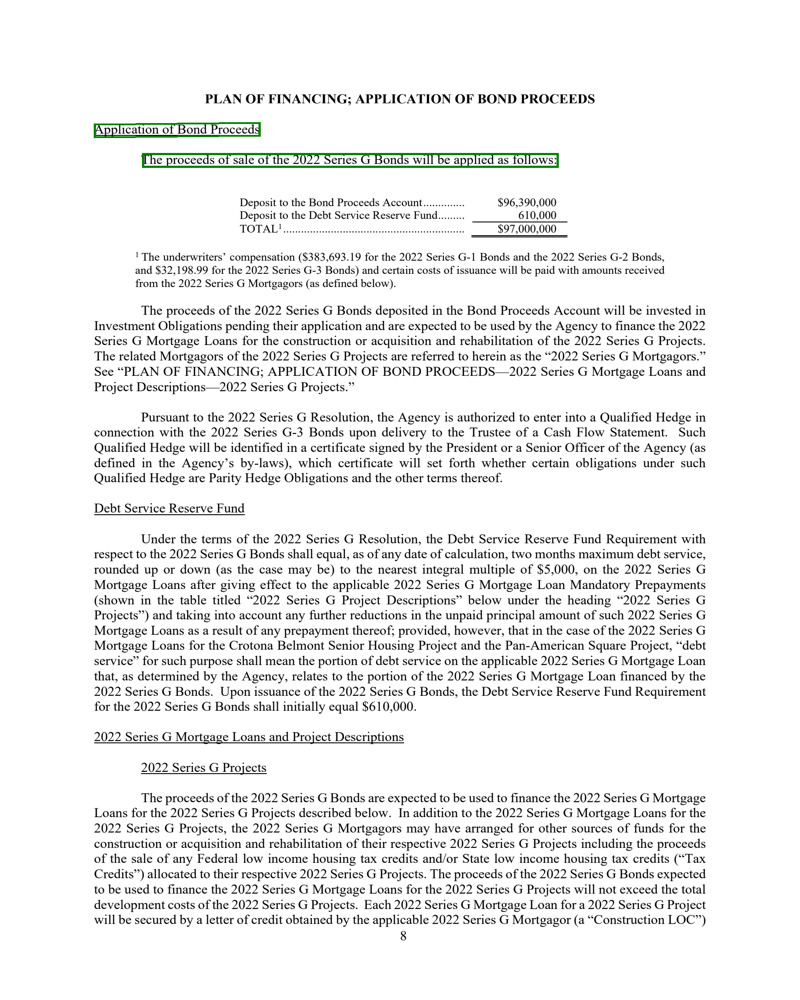

In [91]:
document_bot(question)

## Response

### Question

What is the outstanding balance for mortgages by category?

### Answer

The outstanding balance for mortgages by category is as follows:

Permanent Mortgage Loans: $2,421,835,000
Construction Mortgage Loans: $2,025,419,000

The total outstanding balance for all mortgages is $4,447,254,000.

### Why?

Summary of All Mortgage Loans
Number of
Mortgage
Approximate
Outstanding Principal
Balance of
Mortgage
Percentage of
Total Outstanding
Principal
Balance of
Loans
Loans
Mortgage Loans
Permanent Mortgage Loans
253
$2,421,835,000
54%
Construction Mortgage Loans
102
$2,025,419,000
46%
TOTAL
355
$4,447,254,000
100%

* page: 8, relevance to answer: 0.89
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=8

### Sources

* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=8
	* Document: P11635483-P11259775-P11685317.pdf, page: 8, relevance to question: 0.78
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=8
	* Document: P11635483-P11259775-P11685317.pdf, page: 8, relevance to question: 0.78
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=162
	* Document: P11635483-P11259775-P11685317.pdf, page: 162, relevance to question: 0.74
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=161
	* Document: P11635483-P11259775-P11685317.pdf, page: 161, relevance to question: 0.74
* gs://statmike-mlops-349915/applied-genai/municipal-security/P11635483-P11259775-P11685317.pdf#page=161
	* Document: P11635483-P11259775-P11685317.pdf, page: 161, relevance to question: 0.73        
    

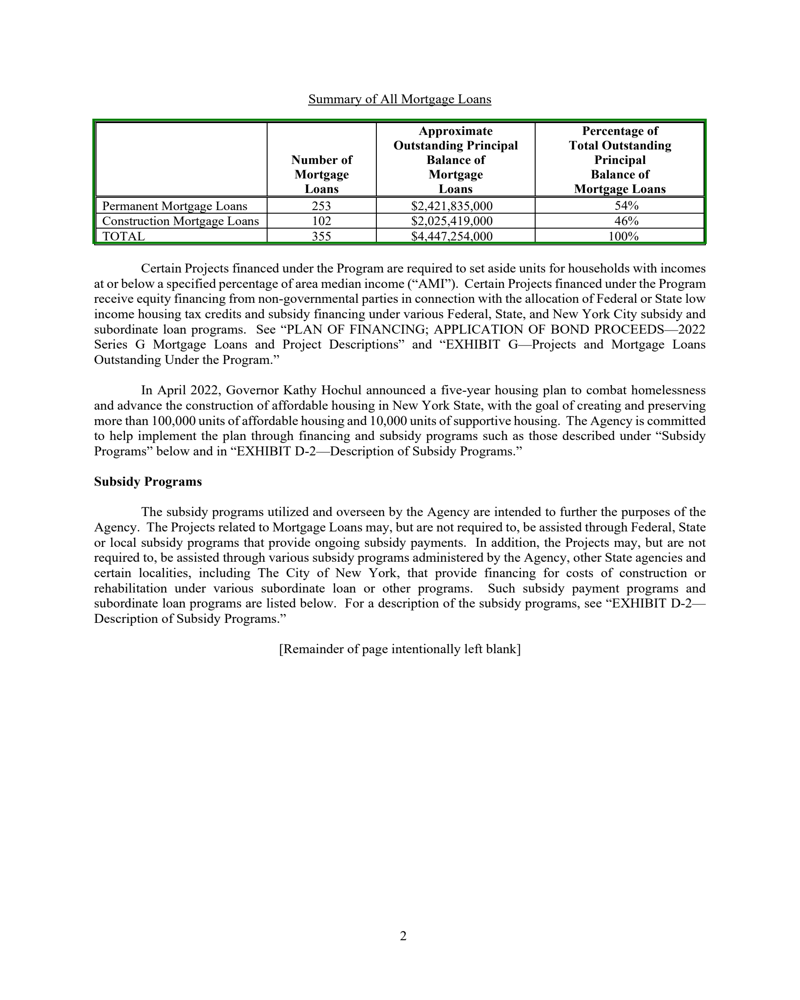

In [92]:
document_bot("What is the outstanding balance for mortgages by category?")